Run using keras environment

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam 
from keras.models import model_from_json
from itertools import zip_longest
import cv2
import numpy as np
import csv, argparse
import os, errno

def file_len(fname):
    i = -1
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

def remove(filename):
    try:
        os.remove(filename)
    except OSError as e:
        if e.errno != errno.ENOENT:
            raise
            
def load_driving_logs(logs, path):
    f = []
    y = []
    for d in logs:
        log = d+'driving_log.csv'
        with open(log,'r') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            for row in reader:
                imgc_file = path + d + row[0].strip()
                imgl_file = path + d + row[1].strip()
                imgr_file = path + d + row[2].strip()
                if (os.path.isfile(imgc_file) & os.path.isfile(imgl_file) & os.path.isfile(imgr_file)):
                    f.append(imgc_file)
                    y.append(np.float32(row[3]))
                    f.append(imgl_file)
                    y.append(np.float32(row[3])+0.2)
                    f.append(imgr_file)
                    y.append(np.float32(row[3])-0.2)
    return f, y
    
def split_driving_log(f, y, train_percent, seed=1973):
    ft = []
    yt = []
    fv = []
    yv = []
    np.random.seed(seed)
    for idx, img in enumerate(f):
        if (np.random.random() <= train_percent):
            ft.append(img)
            yt.append(y[idx])
        else:
            fv.append(img)
            yv.append(y[idx])
    return ft, yt, fv, yv

def grouper(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

def load_image(f):
    img = cv2.imread(f,-1)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img 
    
def extract_csv(log):
    f = []
    y = []
    with open(log,'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            f.append(row[0].strip())
            y.append(np.float32(row[3]))
            f.append(row[1].strip())
            y.append(np.float32(row[3])+0.2)
            f.append(row[2].strip())
            y.append(np.float32(row[3])-0.2)
    return f, y

def gamma_correction(img, correction):
    img = img/255.0
    img = cv2.pow(img, correction)
    return np.uint8(img*255)

def preprocess_image(img):
    img = img[60:140,:,:]
    img = cv2.resize(img,(64, 64))
    return(img)
    
def generate_image(img, y):
    
    angle = y

    X_OFFSET_RANGE = 10
    Y_OFFSET_RANGE = 10
    X_OFFSET_ANGLE = 0.2
    
    img = preprocess_image(img)
    
    bright_factor = 0.2 + (3.8 * np.random.uniform())
    img = gamma_correction(img, bright_factor)

    if (np.random.uniform() > 1.0):
        img = np.fliplr(img)
        angle = -1.0 * angle

    x_translation = (X_OFFSET_RANGE * np.random.uniform()) - (X_OFFSET_RANGE / 2)
    y_translation = (Y_OFFSET_RANGE * np.random.uniform()) - (Y_OFFSET_RANGE / 2)

    angle = angle + ((x_translation / X_OFFSET_RANGE) * 2) * X_OFFSET_ANGLE
    t = np.float32([[1, 0, x_translation], [0, 1, y_translation]])
    img = cv2.warpAffine(img, t, (img.shape[1], img.shape[0]))

    return (img, angle)

            
def generator_random_zero(n, img_dir, logfile):
    f, y = extract_csv(logfile)
    l = len(f)
    while True:
        xs = []
        ys = []
        for _ in range(n):
            i = np.random.randint(low=0,high=l)
            if ( (np.float32(y[i]) >= -0.01 
                    and np.float32(y[i]) <= 0.01 ) 
                    and np.random.uniform() > 0.1 ):
                while (np.float32(y[i]) >= -0.01 
                       and np.float32(y[i]) <= 0.01):
                    i = np.random.randint(low=0,high=l)
            elif ( (np.float32(y[i]) >= -0.21 
                    and np.float32(y[i]) <= -0.19 ) 
                    and np.random.uniform() > 0.1 ):
                while (np.float32(y[i]) >= -0.21 
                       and np.float32(y[i]) <= -0.19):
                    i = np.random.randint(low=0,high=l)
            elif ( (np.float32(y[i]) >= 0.19 
                    and np.float32(y[i]) <= 0.21 ) 
                    and np.random.uniform() > 0.1 ):
                while (np.float32(y[i]) >= 0.19 
                       and np.float32(y[i]) <= 0.21):
                    i = np.random.randint(low=0,high=l)
            img, angle = generate_image(load_image(img_dir+f[i]),np.float32(y[i]))
            xs.append(img)
            ys.append(y[i])
        yield (np.asarray(xs), np.asarray(ys))

def generator_all_batch(n, img_dir, logfile):
    f, y = extract_csv(logfile)
    l = len(f)
    while True:
        xs = []
        ys = []
        for i in range(0,l,n):
            xs.append(preprocess_image(load_image(img_dir+f[i])))
            ys.append(np.float32(y[i]))
            yield (np.asarray(xs), np.asarray(ys))

        
def get_model():
    ch, row, col = 3, 64, 64  

    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=( row, col, ch),
            output_shape=( row, col, ch)))
    model.add(Convolution2D(32, 3, 3, border_mode="same"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3, border_mode="same"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    model.add(ELU())
    model.add(Convolution2D(128, 3, 3, border_mode="same"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))   
    model.add(ELU())
    model.add(Flatten())
    model.add(Dense(512))
    model.add(ELU())
    model.add(Dense(64))
    model.add(ELU())
    model.add(Dense(16))
    model.add(ELU())
    model.add(Dense(1))
    return model



In [31]:
logs = [ 'data/two-laps-middle-forward/',
         'data/two-laps-middle-backwards/',
        'data/two-laps-recovery-forward/']

f, y = load_driving_logs(logs, '/home/mattwg/Projects/carnd-cloning-experiments/')

ft, yt, fv, yv = split_driving_log(f, y, 0.8)

In [32]:
print('all:{} train:{} valid:{}'.format(len(f), len(ft), len(fv)))

all:20697 train:16588 valid:4109


(array([   52.,    82.,   102.,   182.,   213.,   286.,   513.,  1868.,
        4014.,  2811.,  4259.,  4444.,   841.,   451.,   196.,   169.,
          82.,    75.,    40.,    17.]), array([-1.2 , -1.08, -0.96, -0.84, -0.72, -0.6 , -0.48, -0.36, -0.24,
       -0.12,  0.  ,  0.12,  0.24,  0.36,  0.48,  0.6 ,  0.72,  0.84,
        0.96,  1.08,  1.2 ]), <a list of 20 Patch objects>)


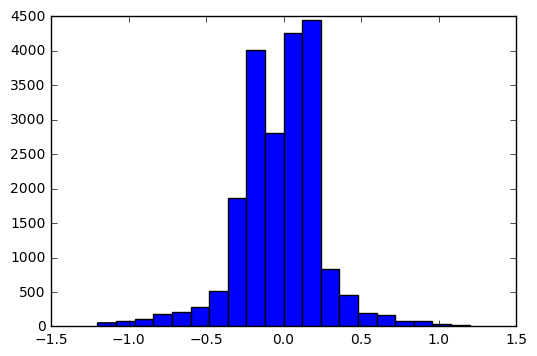

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
h = plt.hist(y, bins=40)
print(h)

In [35]:
def bin_data(f, y, bins):
    fb = {}
    yb = {}
    for idx, img in enumerate(f):
        bin = str((i for i,v in enumerate(bins) if v >= y[idx]).__next__())
        if bin in fb:
            fb[bin].append(img)
            yb[bin].append(y[idx])
        else:
            fb[bin] = [img]
            yb[bin] = [y[idx]]
    return fb, yb

fb, yb = bin_data(f, y, bins = (-999, -0.4, -0.2, -0.1, 0.1, 0.2, 0.4, 999 ))

print([ 'bin:{}={}'.format(k,len(fb[k])) for k in sorted(fb.keys())])
print(sum([len(fb[k]) for k in fb.keys()]))


['bin:1=1271', 'bin:2=5069', 'bin:3=1398', 'bin:4=6157', 'bin:5=4495', 'bin:6=1523', 'bin:7=784']
20697


In [36]:
def generate_balanced(fb, yb, n):
    while True:
        xs = []
        ys = []
        for _ in range(n):
            bin = np.random.randint(low=1, high=8)
            l = len(fb[str(bin)])
            i = np.random.randint(low=0,high=l)
            img, angle = generate_image(load_image(fb[str(bin)][i]),yb[str(bin)][i])
            xs.append(img)
            ys.append(angle)
        yield (np.asarray(xs), np.asarray(ys))
    
g = generate_balanced(fb, yb, 10000)
fg, yg = g.__next__()

(array([   13.,    49.,   105.,   161.,   234.,   347.,   416.,   946.,
         1262.,  1439.,  1437.,  1218.,  1013.,   540.,   358.,   221.,
          140.,    67.,    24.,    10.]),
 array([-1.3921771 , -1.25267953, -1.11318196, -0.97368439, -0.83418682,
        -0.69468925, -0.55519168, -0.41569411, -0.27619654, -0.13669897,
         0.0027986 ,  0.14229617,  0.28179374,  0.42129131,  0.56078888,
         0.70028645,  0.83978402,  0.97928159,  1.11877916,  1.25827673,
         1.3977743 ]),
 <a list of 20 Patch objects>)

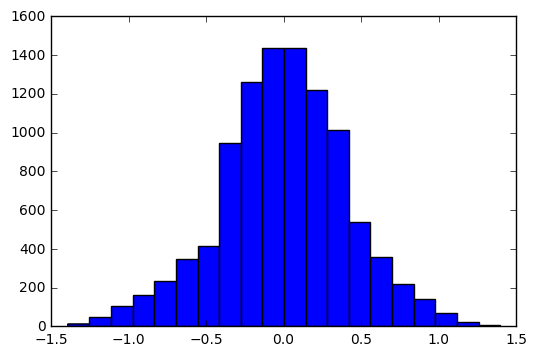

In [37]:
plt.hist(yg, bins = 20)

In [ ]:

parser = argparse.ArgumentParser(description='Train Model')
parser.add_argument('--model', type=str, help='Optional path to model to continue training')
args = parser.parse_args()

image_dir = 'data/images_run01/'

if args.model:
    print('Loading model for continued training!')
    with open(args.model, 'r') as f:
        json = f.read()
        model = model_from_json(json)
else:
    print('Training new model!')
    model = get_model()
    remove('clean_log.csv')
    remove('train_log.csv')
    remove('valid_log.csv')
    clean_driving_log('data/driving_log_3.csv', image_dir)
    split_driving_log('clean_log.csv',0.5)

n_train = file_len('train_log.csv') * 3 
n_valid = file_len('valid_log.csv') * 3

print(n_train, n_valid)

early_stopping_patience = 10
epochs_since_better = 0
n_epochs = 20
continue_training = True
consider_stopping = False
n_epoch = 0

batch_size = 1
n_batches = n_train / batch_size

model.compile(optimizer=Adam(lr=0.00001), loss="mse")

if args.model:
    model.load_weights('model.h5')
    best_mse = model.evaluate_generator(
        generator_all(image_dir,'valid_log.csv'),
        val_samples = 1)
else:
    best_mse = float("inf")
    
while n_epoch < n_epochs and continue_training:
    
    model.fit_generator(
        generator_random_zero(batch_size, image_dir,'train_log.csv'),
        samples_per_epoch=n_batches,
        nb_epoch=1, verbose=0)

    mse = model.evaluate_generator(
        generator_all_batch(2,image_dir,'valid_log.csv'),
        val_samples = 1)
    
    print(mse)
    
    # Early stopping?
    if mse > best_mse:    
        if consider_stopping:
            epochs_since_better += 1
        else:
            consider_stopping = True
            epochs_since_better = 1
    else:
        print('Improved accuracy of {} at epoch {}'.format(mse,n_epoch))
        best_mse = mse
        json = model.to_json()
        with open('model.json', 'w') as f:
            f.write(json)  
        model.save_weights('model.h5')
        consider_stopping = False

    if epochs_since_better > early_stopping_patience:
        print('Stopping no improvement for {} epochs'.format(early_stopping_patience))
        continue_training = False

    
    n_epoch += 1


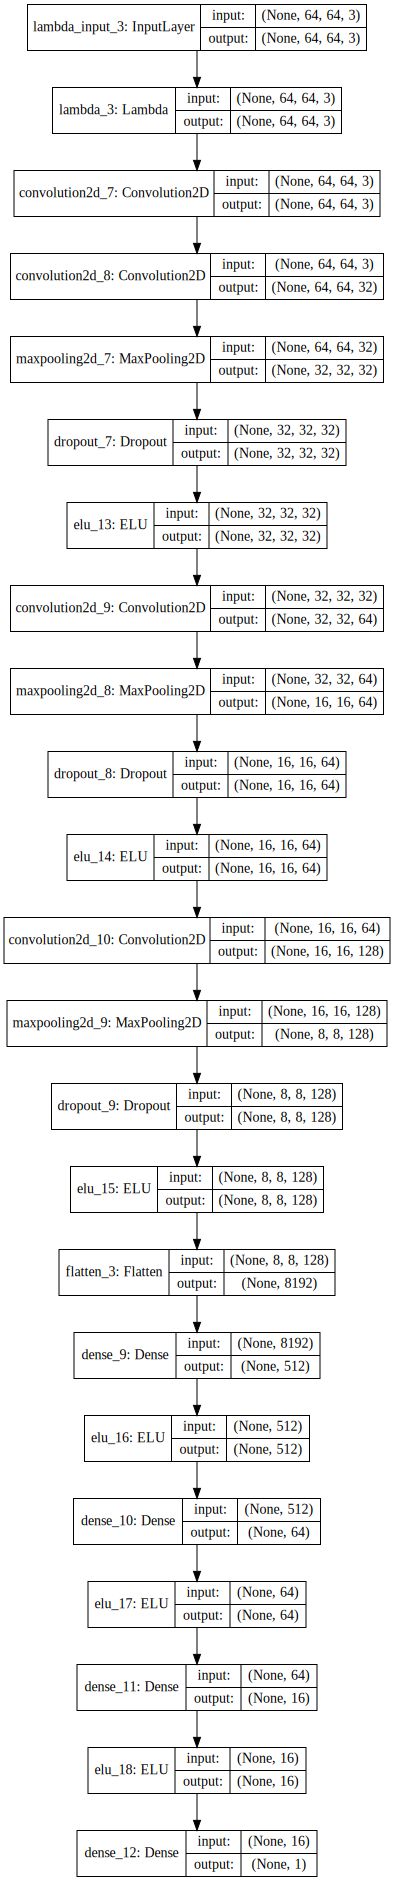

In [44]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

def get_model():
    ch, row, col = 3, 64, 64  

    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=( row, col, ch),
            output_shape=( row, col, ch)))
    model.add(Convolution2D(3, 1, 1, border_mode="same"))
    model.add(Convolution2D(32, 3, 3, border_mode="same"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3, border_mode="same"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    model.add(ELU())
    model.add(Convolution2D(128, 3, 3, border_mode="same"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))   
    model.add(ELU())
    model.add(Flatten())
    model.add(Dense(512))
    model.add(ELU())
    model.add(Dense(64))
    model.add(ELU())
    model.add(Dense(16))
    model.add(ELU())
    model.add(Dense(1))
    return model


model = get_model()

SVG(model_to_dot(model, show_shapes= True).create(prog='dot', format='svg'))